# 1. Import Packages

In [1]:
import numpy as np
from numpy.random import seed
seed(7)
import math
import h5py
from numpy import array
from keras import initializers
from keras.models import Sequential
from keras.models import Model
from keras.layers import LSTM, BatchNormalization, Activation
from keras.layers import Conv1D, MaxPooling1D, Dense, Dropout, Flatten
from keras.layers import RepeatVector
from keras.layers import TimeDistributed
from keras.utils import to_categorical
from keras.optimizers import Adam, SGD
from keras.losses import categorical_crossentropy
from keras.callbacks import LearningRateScheduler, ReduceLROnPlateau, ModelCheckpoint
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import matplotlib.pyplot as plt
import os

Using TensorFlow backend.


# 2. Data Normalization

In [2]:
def scale_data(X):
    #scaler = MinMaxScaler()
    scaler = StandardScaler()
    #scaler.fit(X)
    #ret = scaler.transform(X)
    ret = np.empty(shape = X.shape)
    for idx,r in enumerate(X):
        norm = np.linalg.norm(r)
        scaled = r/norm
        ret[idx] = scaled
    return ret

# 3. Label Smoothing -- only available with Keras 2.3.1+

In [3]:
def cce_function(y_true, y_pred):
    return categorical_crossentropy(y_true, y_pred, label_smoothing=0.1)

# 4. Read Data in Batches

In [4]:
def batch_generator(X, Y, batch_size, shuffle=False):
    indices = np.arange(len(X)) 
    batch=[]
    while True:
        # it might be a good idea to shuffle your data before each epoch
        if shuffle:
            np.random.shuffle(indices) 
        for i in indices:
            batch.append(i)
            if len(batch)==batch_size:
                yield X[batch], Y[batch]
                batch=[]

# 5. Pre-processing Train/Val/Test Data

In [5]:
train_fname = 'vector-data/train.csv'
raw_train = open(train_fname, 'rt')
train_data = np.loadtxt(raw_train, delimiter=",")
train_X = train_data[:,1:8193]
train_Y = train_data[:,8193]
train_X = scale_data(train_X)
train_Y = to_categorical(train_Y, num_classes=5)

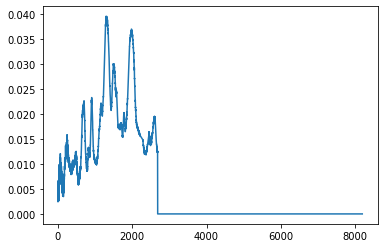

In [6]:
plt.plot(train_X[1])

In [7]:
val_fname = 'vector-data/val.csv'
raw_val = open(val_fname, 'rt')
val_data = np.loadtxt(raw_val, delimiter=",")
val_X = val_data[:,1:8193]
val_Y = val_data[:,8193]
val_X = scale_data(val_X)
val_Y = to_categorical(val_Y, num_classes=5)

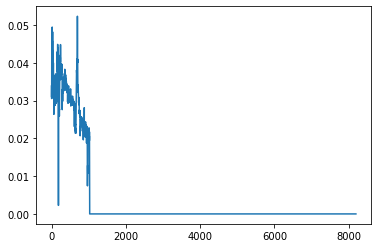

In [8]:
plt.plot(val_X[1287])

In [9]:
test_fname = 'vector-data/test.csv'
raw_test = open(test_fname, 'rt')
test_data = np.loadtxt(raw_test, delimiter=",")
test_X = test_data[:,1:8193]
test_Y = test_data[:,8193]
test_X = scale_data(test_X)
test_Y = to_categorical(test_Y, num_classes=5)

# 6. Model definition -- VGG-16 like

In [10]:
# define model
k = 15
train_X = train_X.reshape((len(train_X), 8192, 1))
val_X = val_X.reshape((len(val_X), 8192, 1))
test_X = test_X.reshape((len(test_X), 8192, 1))

model = Sequential()
model.add(Conv1D(filters=64, kernel_size=k, kernel_initializer='he_normal', padding='same', activation='relu', input_shape=(8192,1)))
model.add(Conv1D(filters=64, kernel_size=k, kernel_initializer='he_normal', padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=4, padding='same'))

model.add(Conv1D(filters=128, kernel_size=k, kernel_initializer='he_normal', padding='same', activation='relu'))
model.add(Conv1D(filters=128, kernel_size=k, kernel_initializer='he_normal', padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=4, strides=4))

model.add(Conv1D(filters=256, kernel_size=k, kernel_initializer='he_normal', padding='same', activation='relu'))
model.add(Conv1D(filters=256, kernel_size=k, kernel_initializer='he_normal', padding='same', activation='relu'))
model.add(Conv1D(filters=256, kernel_size=k, kernel_initializer='he_normal', padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=4, strides=4))

model.add(Conv1D(filters=512, kernel_size=k, kernel_initializer='he_normal', padding='same', activation='relu'))
model.add(Conv1D(filters=512, kernel_size=k, kernel_initializer='he_normal', padding='same', activation='relu'))
model.add(Conv1D(filters=512, kernel_size=k, kernel_initializer='he_normal', padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=4, strides=4))

model.add(Conv1D(filters=512, kernel_size=k, kernel_initializer='he_normal', padding='same', activation='relu'))
model.add(Conv1D(filters=512, kernel_size=k, kernel_initializer='he_normal', padding='same', activation='relu'))
model.add(Conv1D(filters=512, kernel_size=k, kernel_initializer='he_normal', padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=4, strides=4))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.7))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.7))
model.add(Dense(5, activation='softmax'))







Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


# 7. Optimizer and Compiling Model

In [11]:
opt = Adam(lr=1e-5, clipvalue=5)
#model.compile(optimizer=opt, loss=cce_function, metrics=['accuracy'])
model.compile(optimizer=opt, loss=categorical_crossentropy, metrics=['accuracy'])
print(model.summary())



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 8192, 64)          1024      
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 8192, 64)          61504     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 2048, 64)          0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 2048, 128)         123008    
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 2048, 128)         245888    
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 512, 128)          0         
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 512, 256)          491776    
________

# 8. Iteraters, Batch Size, and Callbacks

In [12]:
batch_size = 16
train_it = batch_generator(train_X, train_Y, batch_size, shuffle=True)
val_it = batch_generator(val_X, val_Y, batch_size)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=math.sqrt(0.1),
                              patience=5, min_lr=1e-8, verbose=1)

In [13]:
# Prepare model model saving directory.
save_dir = os.path.join(os.getcwd(), 'saved_models')
#model_name = 'spectra_model.{epoch:03d}.h5'
model_name = 'spectra_model.h5'
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
filepath = os.path.join(save_dir, model_name)

# Prepare callbacks for model saving and for learning rate adjustment.
checkpoint = ModelCheckpoint(filepath=filepath,
                             monitor='val_acc',
                             verbose=1,
                             save_best_only=True)

# 9. Train

In [14]:
model.fit_generator(train_it,
                    steps_per_epoch=len(train_X)//batch_size,
                    validation_data=val_it,
                    validation_steps=len(val_X)//batch_size,
                    epochs=50,
                    callbacks=[reduce_lr, checkpoint],
                    verbose=1)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Epoch 1/50





281/281 [==============================] - 30s 107ms/step - loss: 1.6059 - acc: 0.2186 - val_loss: 1.5868 - val_acc: 0.3266

Epoch 00001: val_acc improved from -inf to 0.32656, saving model to /home1/00946/zzhang/spectra/saved_models/spectra_model.h5
Epoch 2/50
281/281 [==============================] - 25s 89ms/step - loss: 1.5900 - acc: 0.2589 - val_loss: 1.5586 - val_acc: 0.3406

Epoch 00002: val_acc improved from 0.32656 to 0.34063, saving model to /home1/00946/zzhang/spectra/saved_models/spectra_model.h5
Epoch 3/50
281/281 [==============================] - 25s 89ms/step - loss: 1.5657 - acc: 0.2923 - val_loss: 1.5040 - val_acc: 0.3586

Epoch 00003: val_acc improved from 0.34063 to 0.35859, saving model to /home1/00946/zzhang/spectra/saved_models/spectra_model.h5
Epoch 4/50
281/281 [==============================] - 25s 89ms/step - loss: 1.5283 - acc: 0.3305 - val_loss:


Epoch 00026: val_acc did not improve from 0.75313
Epoch 27/50
281/281 [==============================] - 25s 89ms/step - loss: 0.4819 - acc: 0.8298 - val_loss: 0.7182 - val_acc: 0.7352

Epoch 00027: val_acc did not improve from 0.75313
Epoch 28/50
281/281 [==============================] - 25s 89ms/step - loss: 0.4487 - acc: 0.8401 - val_loss: 0.6817 - val_acc: 0.7703

Epoch 00028: val_acc improved from 0.75313 to 0.77031, saving model to /home1/00946/zzhang/spectra/saved_models/spectra_model.h5
Epoch 29/50
281/281 [==============================] - 25s 89ms/step - loss: 0.4303 - acc: 0.8456 - val_loss: 0.6587 - val_acc: 0.7672

Epoch 00029: val_acc did not improve from 0.77031
Epoch 30/50
281/281 [==============================] - 25s 89ms/step - loss: 0.3882 - acc: 0.8643 - val_loss: 0.7171 - val_acc: 0.7672

Epoch 00030: val_acc did not improve from 0.77031
Epoch 31/50
281/281 [==============================] - 25s 89ms/step - loss: 0.3729 - acc: 0.8750 - val_loss: 0.6818 - val_acc

# 10. Validate

In [15]:
val_it = batch_generator(val_X, val_Y, 1)
Y_pred = model.predict_generator(val_it, 1288)
y_pred = np.argmax(Y_pred, axis=1)

print('Confusion Matrix')
print(confusion_matrix(val_data[:,8193], y_pred))

Confusion Matrix
[[252  18  18   7   5]
 [ 18 182  36   4  10]
 [ 27  28 209   8   5]
 [  6  13   5 165  15]
 [  5  12   4  13 223]]


# 11. Test

In [16]:
test_it = batch_generator(test_X, test_Y, 1)
Y_pred = model.predict_generator(test_it, len(test_X))
y_pred = np.argmax(Y_pred, axis=1)

print('Confusion Matrix')
print(confusion_matrix(test_data[:,8193], y_pred))

Confusion Matrix
[[127  10   9   3   1]
 [  3  98  17   2   5]
 [  9  21 102   5   2]
 [  1   3   4  87   8]
 [  3  10   3   7 106]]


# 12. Visualizing Test Result in Confusion Matrix

In [17]:
from sklearn.utils.multiclass import unique_labels

def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'
    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='Measured Performance',
           xlabel='Predicted Performance')
    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")
    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

Confusion matrix, without normalization


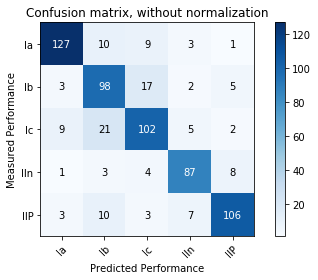

In [18]:
plot_confusion_matrix(array(np.argmax(test_Y, axis=1)), array(y_pred), classes=array(['Ia', 'Ib', 'Ic', 'IIn', 'IIP']), title='Confusion matrix, without normalization')